<a href="https://colab.research.google.com/github/saravanan-a-r/GPT-2-visualization/blob/main/GPT_2_Internals_%5BDemo%5D_Medium_blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  A Simple python script to visualize each step in GPT - 2 Model

In [ ]:
# Install required libraries
!pip install transformers matplotlib seaborn torch --quiet

Tokens: ['What', 'Ġis', 'Ġthe', 'Ġcapital', 'Ġof', 'ĠFrance', '?']
Token IDs: [2061, 318, 262, 3139, 286, 4881, 30]

Sample token embedding for first token 'What':
tensor([-1.7385,  0.0670,  0.4830,  1.3752, -0.6076, -0.0392,  0.1527,  2.0172])

Positional encoding for first token position:
tensor([0., 1., 0., 1., 0., 1., 0., 1.])


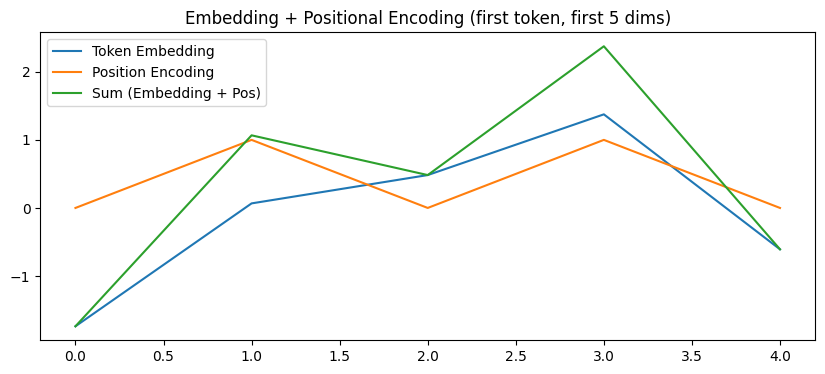


Q vector for first token: [ 6.029912  -1.8802304  1.9814482 -3.0484028 -2.0277157 -0.6533742
  0.5098789 -0.508224 ]


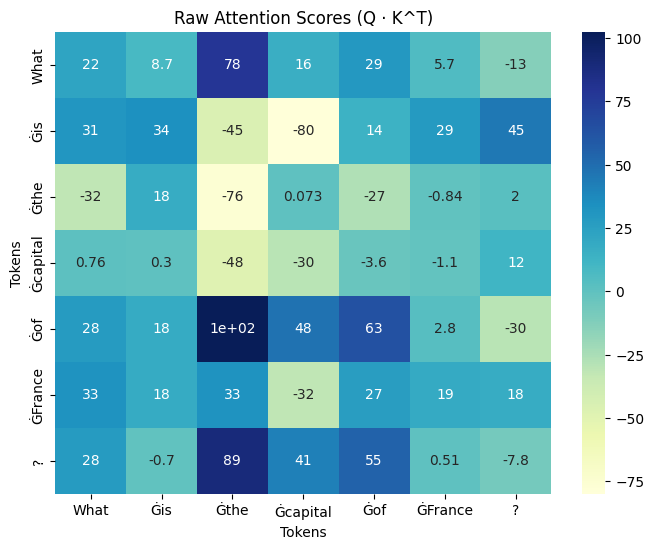

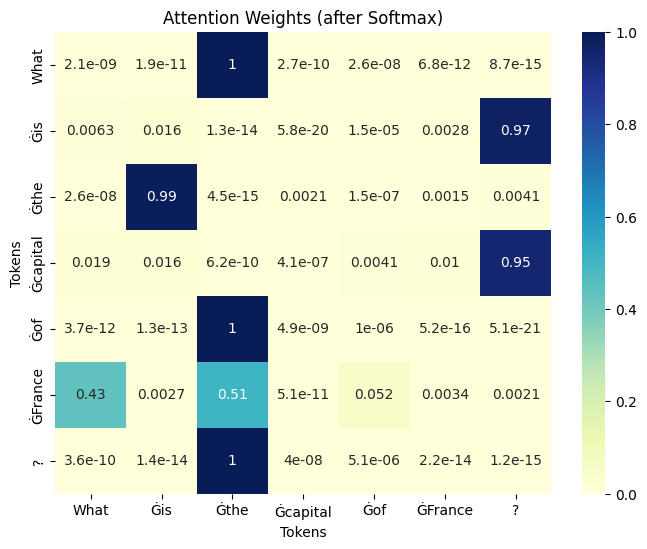


Attention output vector for first token: [ 1.994134    5.5874624   0.3174924   2.9716613  -1.4289187  -0.31710848
 -7.006302    1.5458361 ]

After Add & Norm (first token): [-0.2086455   1.2487037  -0.084555    0.95088947 -0.7307064  -0.12026307
 -1.8278092   0.7723861 ]

FFN output vector for first token: [-11.854888    0.9258045  12.342618  -25.555225    2.02041    -8.65233
   6.8972397  -1.1705021]

After FFN Add & Norm (first token): [-0.77416533  0.45979866  1.3337071  -1.8610352   0.38311556 -0.48895043
  0.710692    0.23683782]

Final output vectors for all tokens (shape): torch.Size([7, 8])


In [ ]:
import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer
import math

# === Utility to plot heatmaps ===
def plot_heatmap(matrix, title, xticklabels=None, yticklabels=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix.detach().numpy(), annot=True, cmap="YlGnBu", xticklabels=xticklabels, yticklabels=yticklabels)
    plt.title(title)
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.show()

# === 1. Tokenization ===
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
sentence = "What is the capital of France?"
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor([token_ids])  # shape: (1, seq_len)
print("Tokens:", tokens)
print("Token IDs:", token_ids)

seq_len = len(tokens)
embedding_dim = 8  # Small dim for visualization

# === 2. Embedding lookup ===
# For simplicity, randomly initialize token embeddings matrix (vocab_size x embed_dim)
torch.manual_seed(0)
vocab_size = tokenizer.vocab_size
token_embedding_matrix = torch.randn(vocab_size, embedding_dim)

# Get token embeddings (seq_len x embed_dim)
embeddings = token_embedding_matrix[input_ids[0]]

print("\nSample token embedding for first token '{}':".format(tokens[0]))
print(embeddings[0])

# === 3. Position encoding ===
# Use sinusoidal positional encoding (like original Transformer paper)
def get_positional_encoding(seq_len, dim):
    pos_enc = torch.zeros(seq_len, dim)
    for pos in range(seq_len):
        for i in range(0, dim, 2):
            pos_enc[pos, i] = math.sin(pos / (10000 ** (i / dim)))
            if i + 1 < dim:
                pos_enc[pos, i + 1] = math.cos(pos / (10000 ** ((i + 1) / dim)))
    return pos_enc

pos_encoding = get_positional_encoding(seq_len, embedding_dim)
print("\nPositional encoding for first token position:")
print(pos_encoding[0])

# Add position encoding to token embeddings
embeddings_pos = embeddings + pos_encoding

# Visualize embeddings before and after position encoding (only first 5 dims for clarity)
plt.figure(figsize=(10, 4))
plt.plot(embeddings[0][:5].detach().numpy(), label="Token Embedding")
plt.plot(pos_encoding[0][:5].detach().numpy(), label="Position Encoding")
plt.plot(embeddings_pos[0][:5].detach().numpy(), label="Sum (Embedding + Pos)")
plt.legend()
plt.title("Embedding + Positional Encoding (first token, first 5 dims)")
plt.show()

# === 4. Transformer Block ===
# Define weight matrices (random for demo)
W_q = torch.randn(embedding_dim, embedding_dim)
W_k = torch.randn(embedding_dim, embedding_dim)
W_v = torch.randn(embedding_dim, embedding_dim)

# 4.a Calculate Q, K, V
Q = embeddings_pos @ W_q
K = embeddings_pos @ W_k
V = embeddings_pos @ W_v

# Visualize Q for first token
print("\nQ vector for first token:", Q[0].detach().numpy())

# 4.b Calculate attention scores (QK^T) and visualize
attention_scores = Q @ K.T  # (seq_len x seq_len)
plot_heatmap(attention_scores, "Raw Attention Scores (Q · K^T)", tokens, tokens)

# 4.c Scale scores and apply softmax
scale = math.sqrt(embedding_dim)
attention_weights = F.softmax(attention_scores / scale, dim=-1)
plot_heatmap(attention_weights, "Attention Weights (after Softmax)", tokens, tokens)

# 4.d Multiply attention weights by V to get attention output
attention_output = attention_weights @ V
print("\nAttention output vector for first token:", attention_output[0].detach().numpy())

# === 5. Add & Norm ===
# Add residual connection (add original embeddings_pos)
residual_1 = attention_output + embeddings_pos

# Layer Norm (simplified: mean=0, std=1 normalization per vector)
def layer_norm(x, eps=1e-6):
    mean = x.mean(dim=-1, keepdim=True)
    std = x.std(dim=-1, keepdim=True)
    return (x - mean) / (std + eps)

norm_1 = layer_norm(residual_1)

print("\nAfter Add & Norm (first token):", norm_1[0].detach().numpy())

# === 6. Feed Forward Network (FFN) Layer ===
# FFN is usually two linear layers with activation in between
# Define weights for FFN (smaller intermediate dim for demo)
ffn_hidden_dim = 16
W1 = torch.randn(embedding_dim, ffn_hidden_dim)
b1 = torch.randn(ffn_hidden_dim)
W2 = torch.randn(ffn_hidden_dim, embedding_dim)
b2 = torch.randn(embedding_dim)

# FFN forward pass
ffn_hidden = F.relu(norm_1 @ W1 + b1)
ffn_output = ffn_hidden @ W2 + b2

print("\nFFN output vector for first token:", ffn_output[0].detach().numpy())

# === 7. Add & Norm after FFN ===
residual_2 = ffn_output + norm_1
norm_2 = layer_norm(residual_2)

print("\nAfter FFN Add & Norm (first token):", norm_2[0].detach().numpy())

# === Summary ===
print("\nFinal output vectors for all tokens (shape):", norm_2.shape)

# You can imagine norm_2 vectors now passed to the next transformer block or output layer
